v2 note:
replace data with cleanded dataset

In [ ]:
# Music Characteristics + lyrics embedding + artists embedding (use Bert)

import os
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import re
from google.colab import drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 1. data importing
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CS5242 Assignment'
df_all = pd.read_csv(file_path+'/spotify_songs.csv')
train_df = pd.read_csv(file_path+'/train_df_with_artist.csv')
test_df = pd.read_csv(file_path+'/test_df_with_artist.csv')
# train_df = pd.merge(df_train, df_all[['lyrics', 'track_artist','danceability','energy','loudness','speechiness']], on=['danceability','energy','loudness','speechiness','lyrics'], how='left')
# test_df = pd.merge(df_test, df_all[['lyrics', 'track_artist','danceability','energy','loudness','speechiness']], on=['danceability','energy','loudness','speechiness','lyrics'], how='left')


# Encoding genre and artist
all_artists = pd.concat([train_df['track_artist'], test_df['track_artist']])
artist2idx = {artist: idx for idx, artist in enumerate(all_artists.astype('category').cat.categories)}

train_df['artist_idx'] = train_df['track_artist'].map(artist2idx)
test_df['artist_idx'] = test_df['track_artist'].map(artist2idx)

all_genre = pd.concat([train_df['playlist_genre'], test_df['playlist_genre']])
genre2idx = {genre: idx for idx, genre in enumerate(all_genre.astype('category').cat.categories)}

train_df['genre_idx'] = train_df['playlist_genre'].map(genre2idx)
test_df['genre_idx'] = test_df['playlist_genre'].map(genre2idx)


# 2. remove empty lyrics
audio_cols = ['danceability','energy','loudness','speechiness','instrumentalness', 'duration_ms']


train_df = train_df[~(train_df['lyrics'].isna() | (train_df['lyrics'].str.strip() == '') |
         (train_df['lyrics'].str.strip().str.lower().str.startswith("lyrics for this song have yet to be released")))].copy()

drop_mask = (
    train_df['lyrics'].isna() |
    (train_df['lyrics'].str.strip() == '') |
    (train_df['lyrics'].str.strip().str.lower().str.startswith("lyrics for this song have yet to be released"))
)
train_df = train_df[~drop_mask].copy()

num_artists = all_artists.nunique()
num_genres = all_genre.nunique()

# calculate the weight, because pop outnumber other genre
labels = train_df['genre_idx'].values
classes = np.unique(labels)
weights = compute_class_weight('balanced', classes=classes, y=labels)
class_weights = torch.tensor(weights, dtype=torch.float)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 3. split train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['genre_idx'], random_state=42)


# 4. Tokenizer
def simple_tokenizer(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

def build_vocab(texts, vocab_size=10000):
    tokenized = [simple_tokenizer(t) for t in texts]
    counter = Counter(tok for tokens in tokenized for tok in tokens)
    special_tokens = ['<PAD>', '<UNK>']
    most_common = counter.most_common(vocab_size - len(special_tokens))
    vocab = special_tokens + [w for w, _ in most_common]
    word2idx = {w: i for i, w in enumerate(vocab)}
    return word2idx, vocab

def encode_text(text, word2idx, max_len=256):
    tokens = simple_tokenizer(text)
    ids = [word2idx.get(t, word2idx['<UNK>']) for t in tokens]
    ids = ids[:max_len] + [word2idx['<PAD>']] * max(0, max_len - len(ids))
    mask = [1 if i != word2idx['<PAD>'] else 0 for i in ids]
    return ids, mask

all_lyrics = pd.concat([train_df['lyrics'], test_df['lyrics']])

word2idx, vocab = build_vocab(all_lyrics.tolist())

def add_tokenized_columns(df, word2idx, max_len=256):
    result = [encode_text(text, word2idx, max_len) for text in df['lyrics']]
    df['lyrics_input_ids'] = [r[0] for r in result]
    df['lyrics_attention_mask'] = [r[1] for r in result]
    return df

train_df = add_tokenized_columns(train_df, word2idx)
val_df = add_tokenized_columns(val_df, word2idx)
test_df = add_tokenized_columns(test_df, word2idx)


In [ ]:
# 5. Dataset

audio_dim = len(audio_cols) + 1

class SongsDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_vals = row[audio_cols].to_numpy(dtype=np.float32)
        audio = torch.from_numpy(audio_vals)
        missing_flag = torch.tensor([float(False)], dtype=torch.float)
        audio_feat = torch.cat((audio, missing_flag), dim=0)
        input_ids = torch.tensor(row['lyrics_input_ids'], dtype=torch.long)
        attention_mask = (input_ids != word2idx['<PAD>']).long()
        artist = torch.tensor(row['artist_idx'], dtype=torch.long)
        label = torch.tensor(row['genre_idx'], dtype=torch.long)
        return audio_feat, input_ids, attention_mask, artist, label

train_ds = SongsDataset(train_df)
val_ds = SongsDataset(val_df)
test_ds = SongsDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# ------------------------- Model (GRU + Cross Attention) ----------------------------
class MultiModalNet(nn.Module):
    def __init__(self, num_artists, num_genres, audio_dim, vocab_size, hidden_dim=128):
        super().__init__()
        self.text_emb = nn.Embedding(vocab_size, hidden_dim)
        self.lyrics_gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)

        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.artist_emb = nn.Embedding(num_artists, 32)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + 32, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, num_genres)
        )

    def forward(self, audio_feat, input_ids, attention_mask, artist):
        t = self.text_emb(input_ids)                  # (B, L, D)
        t, _ = self.lyrics_gru(t)                     # (B, L, D)
        q = self.audio_proj(audio_feat).unsqueeze(1)  # (B, 1, D)
        attn_out, _ = self.cross_attn(q, t, t, key_padding_mask=(1 - attention_mask).bool())
        fused = attn_out.squeeze(1)
        g = self.artist_emb(artist)
        x = torch.cat([fused, g], dim=1)
        return self.classifier(x)


In [ ]:
# 7. prep for training：
model = MultiModalNet(num_artists, num_genres, audio_dim, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)



In [ ]:
# 8. Tran & Val
for epoch in range(7):
    model.train()
    total_loss = 0
    for audio_feat, input_ids, attention_mask, artist, labels in tqdm(train_loader, desc=f"Train E{epoch+1}"):
        audio_feat, input_ids, attention_mask, artist, labels = [x.to(device) for x in (audio_feat, input_ids, attention_mask, artist, labels)]
        optimizer.zero_grad()
        logits = model(audio_feat, input_ids, attention_mask, artist)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for audio_feat, input_ids, attention_mask, artist, labels in val_loader:
            audio_feat, input_ids, attention_mask, artist, labels = [x.to(device) for x in (audio_feat, input_ids, attention_mask, artist, labels)]
            preds = model(audio_feat, input_ids, attention_mask, artist).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Val Accuracy: {correct/total:.4f}")

# 9. Save Model
torch.save(model.state_dict(), 'multimodal_genre_finetuned.pth')
print("Model weights saved to  multimodal_genre_finetuned.pth")



Train E1: 100%|██████████| 751/751 [00:16<00:00, 45.47it/s]


Epoch 1 | Train Loss: 1.3457
Val Accuracy: 0.5468


Train E2: 100%|██████████| 751/751 [00:12<00:00, 62.20it/s]


Epoch 2 | Train Loss: 1.1189
Val Accuracy: 0.5933


Train E3: 100%|██████████| 751/751 [00:11<00:00, 66.38it/s]


Epoch 3 | Train Loss: 0.9589
Val Accuracy: 0.6075


Train E4: 100%|██████████| 751/751 [00:11<00:00, 66.31it/s]


Epoch 4 | Train Loss: 0.7870
Val Accuracy: 0.6112


Train E5: 100%|██████████| 751/751 [00:11<00:00, 66.19it/s]


Epoch 5 | Train Loss: 0.6246
Val Accuracy: 0.5895


Train E6: 100%|██████████| 751/751 [00:10<00:00, 68.96it/s]


Epoch 6 | Train Loss: 0.4812
Val Accuracy: 0.5918


Train E7: 100%|██████████| 751/751 [00:10<00:00, 69.00it/s]


Epoch 7 | Train Loss: 0.3661
Val Accuracy: 0.6142
Model weights saved to  multimodal_genre_finetuned.pth


Test Accuracy: 0.6118


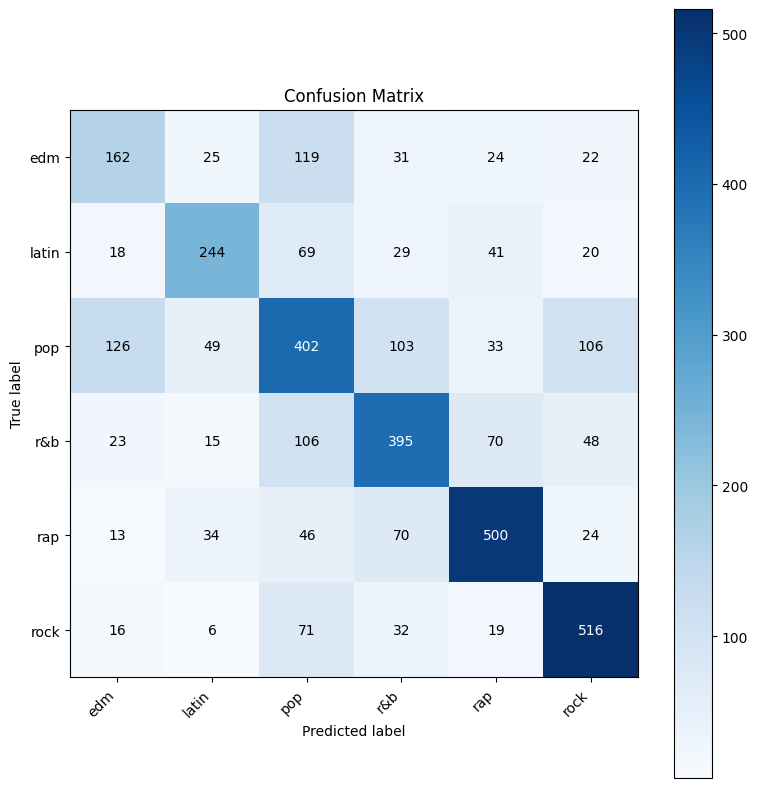

Saved as confusion_matrix.png


In [ ]:
# ────────────────── 10. Results ──────────────────

#  eval
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for audio_feat, input_ids, attention_mask, artist, labels in test_loader:
        audio_feat, input_ids, attention_mask, artist = [x.to(device) for x in (audio_feat, input_ids, attention_mask, artist)]
        logits = model(audio_feat, input_ids, attention_mask, artist)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = train_df['playlist_genre'].astype('category').cat.categories.tolist()


fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')

plt.tight_layout()
plt.show()
fig.savefig('confusion_matrix.png')
print("Saved as confusion_matrix.png")



In [ ]:
print("\n Classification Report:")
idx2genre = [genre for genre, idx in sorted(genre2idx.items(), key=lambda x: x[1])]

# Print classification report
print(classification_report(all_labels, all_preds, target_names=idx2genre, digits=4))



 Classification Report:
              precision    recall  f1-score   support

         edm     0.4525    0.4230    0.4372       383
       latin     0.6542    0.5796    0.6146       421
         pop     0.4945    0.4908    0.4926       819
         r&b     0.5985    0.6012    0.5998       657
         rap     0.7278    0.7278    0.7278       687
        rock     0.7011    0.7818    0.7393       660

    accuracy                         0.6118      3627
   macro avg     0.6048    0.6007    0.6019      3627
weighted avg     0.6092    0.6118    0.6098      3627



In [ ]:
# 把 index 映射回名字
pred_labels = [idx2genre[p] for p in all_preds]

preds_df = pd.DataFrame({
    'prediction': pred_labels
})

preds_df.to_csv(file_path+'/GRU_result.csv', index=False)


In [ ]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1647910
